In [1]:
#@title Install prerequsite: you may have to do Runtime -> Restart runtime after the installation

!pip install --upgrade pip
!pip install --upgrade setuptools wheel
!pip install --upgrade "mxnet<2.0.0"
!pip install autogluon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 8.6 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
numba 0.56.2 requires setuptools<60, but you have setuptools 65.5.0 which is incompatible.
Looking in indexes: https:/

In [2]:
# try out if you can load autogluon ok, if not, try restart your runtime and 
# redo the installation

import autogluon

# 2022-10-17 RNASeq Data Analysis and Machine Learning


In [5]:
#@title Mount Google Drive (You don't need to run this if you are running notebooks on your laptop)

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Mounted at /content/drive


## Tumor-educated platelets (TEP) classifier using machine learning



PLatelets, or thrombocytes, are a component of blood that help promote blood clotting and wound healing. As plateletts are the second most abundant cell type in peripheral blood, and their functions drive them to respond to leisions in the body, it has been reported that tumor-educated platelets, or TEP, may enable blood-based cancer diagnostics. Such blood-based "liquid biopsies" provide a means for minimally invasive molecular diagnostics and allow early detection. In this exercise, we'll use the data from [Best _et al._](https://doi.org/10.1016/j.ccell.2015.09.018) to use RNASeq data of tumor-educated platelets and platelets from healthy donors to perform cancer diagnosis and even classifying the primary location of the cancer type using machine-learning approach.

You can download the normalized gene expression matrix and the meta data here:

[tep_gse68086_tmmcpm.txt](https://drive.google.com/file/d/1--SDFwNViXuqdXmc5q-h5PQHoG8_2mUG/view?usp=sharing)

[tep_gse68086_meta.txt](https://drive.google.com/file/d/1-1-H-8p6nTr7h7-IC8YAS28h8ePNYOMN/view?usp=sharing)


For the expression values, in order to correct for batch effects caused by sequencing batches, we used TMM-normalized CPM values to convert the raw count to "normal-like" values, and use a linear model to remove batch-specific effects. If you are interested in how to do that, please see [this analysis](https://drive.google.com/file/d/1-3QUJ0pio0_pgeYLUWvebFtcfFYr2aHC/view?usp=sharing) for details.

In [6]:
# Set data file location
# If you are running notebooks on your laptop, change this to the directory
# where you put downloaded files

from pathlib import Path

DATA = Path("/content/drive/My Drive/2022 ECBM E4060/data/2022-10-17")

In [7]:
import pandas as pd

ge = pd.read_csv(DATA / "tep_gse68086_tmmcpm.txt", sep="\t", index_col=0)
ge.head()

,Blood_Platelets_Chol-460,Blood_Platelets_HC-18,Blood_Platelets_Chol-611,Blood_Platelets_Panc-327,Blood_Platelets_HC-14,Blood_Platelets_CRC-272,Blood_Platelets_GBM-471,Blood_Platelets_HC-17,Blood_Platelets_HC-10,Blood_Platelets_CRC-276,...,Blood_Platelets_Lung-01,Blood_Platelets_Breast-H76,Blood_Platelets_Lung-0082,Blood_Platelets_Chol-379,Blood_Platelets_Lung-L11,Blood_Platelets_Breast-H63,Blood_Platelets_Lung-L.15,Blood_Platelets_Lung-L19,Blood_Platelets_Lung-L.13,Blood_Platelets_Chol-376
A2M,0.0769,0.5597,1.5302,5.5208,0.5597,0.8462,0.0769,4.4795,0.5597,0.8462,...,0.8462,2.6257,1.5673,1.4486,2.2334,2.8331,2.3265,3.2770,3.3145,0.5597
AAAS,-0.9441,3.9159,0.7216,2.9145,4.5023,0.1974,1.8377,3.0486,-0.5084,0.1974,...,0.1974,0.2530,0.9490,-0.5084,3.9010,2.3864,1.8650,2.5115,1.7386,3.0744
AACS,0.2120,0.1638,1.4159,-0.1724,1.8839,0.2991,0.2120,-0.1724,1.6878,0.2991,...,0.2991,-0.5496,0.2120,-0.1724,2.1311,-0.5496,0.2120,1.3749,0.2120,-0.1724
AAGAB,2.2824,4.6500,3.0256,3.5574,4.4619,3.8709,3.1244,4.8235,4.1744,5.3702,...,0.1886,4.9659,4.6361,4.8336,4.2795,4.0040,2.8906,4.7043,2.9779,4.9759
AAK1,1.6529,2.5860,0.9499,0.5141,3.3072,1.4772,2.2424,3.3242,1.2662,0.9527,...,2.1557,1.5787,0.0286,0.8313,2.0578,-0.1463,0.4221,0.3386,-0.2209,2.5869


In [8]:
meta = pd.read_csv(DATA / "tep_gse68086_meta.txt", sep="\t")
meta.head()

,sample_title,cell_type,mutational_subclass,cancer_type,batch,patient_id,tissue,sample_name,geo_accession,subset
0,Blood_Platelets_Chol-460,Thrombocytes,wt,Hepatobiliary,Batch04,Chol-460,blood,Chol-460,GSM1662565,test
1,Blood_Platelets_HC-18,Thrombocytes,wt,HC,Batch03,HC-18,blood,HD-39-1,GSM1662663,test
2,Blood_Platelets_Chol-611,Thrombocytes,wt,Hepatobiliary,Batch04,Chol-611,blood,Chol-611,GSM1662566,test
3,Blood_Platelets_Panc-327,Thrombocytes,KRAS,Pancreas,Batch03,Panc-327,blood,327-Pancr-KRAS,GSM1662747,test
4,Blood_Platelets_HC-14,Thrombocytes,wt,HC,Batch03,HC-14,blood,HD-16-1,GSM1662659,train


You can find the cancer types of each samples (`HC` for healthy control) and the assigned `train` and `test` subset [according to the original paper](https://www.cell.com/cms/10.1016/j.ccell.2015.09.018/attachment/726cb5ec-f79e-4d2b-aa9a-fb858dad1a65/mmc2.xlsx) for building a machine learning model. Note the original paper use the term `validation` for our test set. Since we will use the terminology `validation` set as the held-out set apart from `train` set for hyperparameter tuning and model selection, we rename the subset for determining final model performance as `test ` set.

In [9]:
meta.groupby("subset").geo_accession.nunique()

subset
test     108
train    177
Name: geo_accession, dtype: int64

We see that we split 108 samples as the test set. We can also check how many samples per each cancer type and healthy control we have in each subset as well.

In [10]:
meta.groupby(["subset", "cancer_type"]).geo_accession.nunique()

subset  cancer_type  
test    Breast           16
        CRC              16
        GBM              16
        HC               16
        Hepatobiliary     6
        Lung             24
        Pancreas         14
train   Breast           23
        CRC              26
        GBM              24
        HC               39
        Hepatobiliary     8
        Lung             36
        Pancreas         21
Name: geo_accession, dtype: int64

## Feature selection



As the number of genes are enormous, while the sample size is always limited, one way to prevent overfitting is to prefilter the number of features (genes).  

In a common machine learning problem, feature selection methods include the following:

1. Select top genes based on its association with target variable ([SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest), [SelectPercentile](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile)), or simply based on its variance ([VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold))

2. Select features based on model fitting result and remove the least informative features ([RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE) or [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel))

The single gene selections in 1 is very much similar to what we do in differential expression. Using the methods in `scikit-learn` is just a quick and dirty way to pick up the genes without doing more rigorous statistical model fitting. One important note is that whenever we perform feature selection, we should only do it the **training set**. Involving the testing / validation sets in feature selection process is basically cheating by leaking information in the evaluation process into the training process.

Here we introduced a quite generalizable metric to quantify the association between individual feature and the target variable: [Mutual Information](https://en.wikipedia.org/wiki/Mutual_information). Born from Information Theory, mutual information quantifies the dependence between two random variables. As it is fully derived from probability, it is more agnostic to the distribution of the variables than statistical metrics such as correlation coefficient, but at the same time also more sensitive. It can be directly applied to binary classification, multi-class classification, or regression problems.

In `scikit-learn` package, you can use the [`mutual_info_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) function to calculate the mutual information between features and a categorical / discrete target variable. On the side, you can use [`mutual_info_regression`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression) for that between features and a continuous target variable.


In [12]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder

import numpy as np

# fix random seed for reproducibility
np.random.seed(4060)

In [13]:
# Creating training and testing data. 
x_train = ge[meta[meta.subset == "train"].sample_title].transpose()
y_train = meta.loc[(meta.subset == "train").values, "cancer_type"]
x_test = ge[meta[meta.subset == "test"].sample_title].transpose()
y_test = meta.loc[(meta.subset == "test").values, "cancer_type"]

In [14]:
# create a dataframe containing mutual information for each feature
midf = pd.DataFrame({
    "feature": x_train.columns.values,
    "mi": mutual_info_classif(x_train, y_train),
}).sort_values("mi", ascending=False)

In [15]:
midf.head()

,feature,mi
2767,FCMR,0.448211
1171,CCDC141,0.445585
8407,TRABD2A,0.445297
2381,EIF1AY,0.440990
8440,TRAT1,0.437609


With the MI between the target variable and each gene calculated, we will need to set a cutoff in terms of how many genes we would like to use in the model. There are two considerations: first, the training set only have 170 samples here, we do not want to use features that's larger than the samples as it tends to lead to overfitting or converging issue. Second, we should observe the distribution of the MIs from highest to lowest, trying to see if there is any sudden drop indicating the there might be a subset if features more informative than the others. 

Therefore, let's sort the MIs and plot the top 200 to observe if there is such behavior.

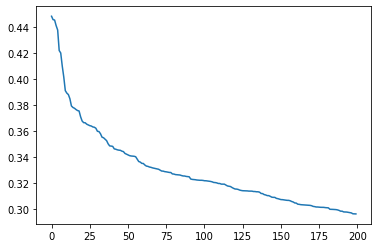

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(200), midf.mi.iloc[:200])

The biggest drops happens in the first few features. However selecting < 10 features for AutoML models will likely lead to suboptimal outcome. We see several obvious drops around MI = 0.36 (around 25 genes) MI = 0.34 (around 50 genes) and MI = 0.32 (around 87 genes). Here let's try to match the number of features equal to the number of samples, we'll set a cutoff `MI >= 0.31`, which will give us 143 genes.

In [17]:
selected_genes = midf.loc[midf.mi >= 0.31, "feature"]

In [18]:
len(selected_genes)

143

## Baseline model evaluation


To demonstrate the usefulness of AutoML, let's build a baseline model using the simplest [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) model. The [`LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV) class in `scikit-learn` will automatically perform cross-validation and select the useful features based on the regularization criteria you set (the `penalty` parameter). Choose `penalty='l1'` for LASSO regression and `penalty='l2'` for ridge regression.

In [19]:
# build a baseline model using LogisticRegressionCV

from sklearn.linear_model import LogisticRegressionCV
import numpy as np

# set random seed for reproducibility
np.random.seed(4060)
lr = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear')
lr.fit(x_train[selected_genes], y_train)

LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear')

Once the model is trained, we can use the following code to generate prediction.

In [20]:
lr.classes_

array(['Breast', 'CRC', 'GBM', 'HC', 'Hepatobiliary', 'Lung', 'Pancreas'],
      dtype=object)

In [21]:
# the raw prediction values from predict_proba function are just scores the
# model predicted for each class

y_pred_score = lr.predict_proba(x_test[selected_genes])

# you can also use predict function to directly ask model to output the
# predicted class

y_pred = lr.predict(x_test[selected_genes])

We can try to evaluate several different metrics:

1. `Accuracy`: what percentage of samples got correct prediction
2. `Balanced accuracy`: weighted accuracy by giving more weight to classes with smaller sample sizes 
3. `AUROC`: Area under Receiver Operating Characteristics (ROC) curve. Note we'll use `weighted` average to account for imbalance of the sample size in each class
4. `F1` score: Harmonic mean of the precision and recall

In [22]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                             roc_auc_score, f1_score)
def performance_scores(y_true, y_pred_score, y_pred=None):
    # We can find which class has the highest score as its predicted class
    if y_pred is None:
        y_pred = y_pred_score.argmax(axis=1)
        
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "auroc": roc_auc_score(y_true, y_pred_score, average="weighted",
                               multi_class="ovr"),
        "f1": f1_score(y_true, y_pred, average="weighted")
    }

In [23]:
performance_scores(y_test, y_pred_score, y_pred)

{'accuracy': 0.3333333333333333,
 'balanced_accuracy': 0.3239795918367347,
 'auroc': 0.7624630221773843,
 'f1': 0.27952674897119345}

We see that the baseline model has 32.4% of the chances of giving the correct prediction among all 7 classes (which is better than random guess). We can also check how the performance is if we only consider tumor versus normal.

In [24]:
# make the target variable binary (tumor vs non-tumor)
y_test_bin = (y_test == "HC").astype(int)
y_pred_score_bin = y_pred_score[:, lr.classes_ == "HC"]
y_pred_bin = (y_pred == "HC").astype(int)

In [25]:
performance_scores(y_test_bin, y_pred_score_bin, y_pred=y_pred_bin)

{'accuracy': 0.8703703703703703,
 'balanced_accuracy': 0.7432065217391304,
 'auroc': 0.9279891304347825,
 'f1': 0.8703703703703703}

In terms of tumor vs normal prediction, the accuracy is already 87.0%, meaning the TEPs are really quite different in terms of transcriptomic profiles from the normal platelets.

#### Confusion matrix


Another way to diagnose the performance is to draw a confusion matrix. This can be easily done by using the `consufion_matrix` function in `sklearn.metrics` module.

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [27]:
cm = confusion_matrix(y_test, y_pred)

We can visualize the confusion matrix by `ConfusionMatrixDisplay` class.

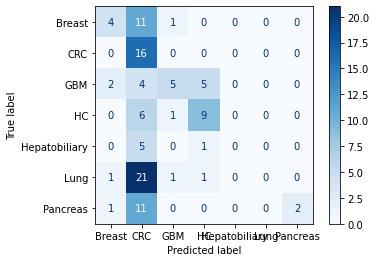

In [28]:
disp = ConfusionMatrixDisplay(cm, display_labels=lr.classes_)
disp.plot(cmap="Blues")

## Search for best performing models using AutoML

There are many different types of machine learning models. For each type of model, there are several input arguments, or hyperparameters, that will affect model performance. To identify the best type of model for your data, you will need to try out various combinations of (model type, hyperparameters) and use cross validation on the **training set** to find which combination leads to the best held-out validation performance. This is a very computational heavy but systematic process. Recently, there has been multiple initiatives in the machine learning community to automate such process. Automated machine learning (AutoML), combines basic feature preprocessing (e.g. feature filtering, one-hot encoding, missing value imputatoin), model selection, hyperparameter tuning, and cross validation all together into one function call. This allows people without comprehensive machine learning training to perform rigorous model training up to the expert's standard, or experienced data scientists to save the time writing model training framework by simply doing one function call.

[AutoGluon](https://autogluon.mxnet.io/v0.0.14/index.html) is a relatively new member to the AutoML tool family, but already has shown great promises to be one of the best performing and easy to use tools not only in the open-source world but also outperforms lots of commercial tools. We will use it to search for a best model to perdict whether the source of the platelets.

In [29]:
from autogluon.tabular import TabularPredictor

In [30]:
train_data = x_train.loc[:, selected_genes].copy()
train_data["cancer_type"] = y_train.values

predictor = TabularPredictor(label="cancer_type", path="good_quality_covid").fit( 
    train_data=train_data,
    presets="good_quality_faster_inference_only_refit",
)

INFO:autogluon.core.utils.decorators:Preset alias specified: 'good_quality_faster_inference_only_refit' maps to 'good_quality'.
INFO:autogluon.tabular.predictor.predictor:Presets specified: ['good_quality_faster_inference_only_refit']
INFO:autogluon.tabular.predictor.predictor:Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=5, num_bag_sets=1
INFO:autogluon.tabular.learner.default_learner:Beginning AutoGluon training ...
INFO:autogluon.tabular.learner.default_learner:AutoGluon will save models to "good_quality_covid/"
INFO:autogluon.tabular.learner.default_learner:AutoGluon Version:  0.5.2
INFO:autogluon.tabular.learner.default_learner:Python Version:     3.7.15
INFO:autogluon.tabular.learner.default_learner:Operating System:   Linux
INFO:autogluon.tabular.learner.default_learner:Train Data Rows:    177
INFO:autogluon.tabular.learner.default_learner:Train Data Columns: 143
INFO:autogluon.tabular.learner.default_learner:Label Column: cancer_type
INFO:autogluon.ta

To initiate an AutoML job, similar to models in `scikit-learn` library, we use the `fit` function, with slightly different arguments. AutoGluon has several `presets` settings that are just bundles of arguments to allow user to choose based on the trade off among model complexity, model performance, training time, and inference time. See its [documents](https://autogluon.mxnet.io/v0.0.14/api/autogluon.task.html) for how each preset means and pick the one that fit best to your needs. You may also try to configure individual argument to have customed setting. I generally recommend `good_quality_faster_inference_only_refit`. In this setting, AutoGluon will perform stacking to build [ensemble models](https://en.wikipedia.org/wiki/Ensemble_learning) that generally would boost the model performance significantly, and retrain the models after finding the best combination to allow faster inference time and smaller model size. 

In [31]:
# Backup the result
# !rsync -auzv good_quality /content/drive/My\ Drive/ecbm_e4060_staging/

You can check the model trianing log and how each model performs in terms of cross validation using the `fit_summary` function.

In [32]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                           model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0                LightGBM_BAG_L1   0.666667       0.023029   13.771992                0.023029          13.771992            1      False          3
1            WeightedEnsemble_L2   0.666667       0.023828   14.167096                0.000799           0.395104            2      False         12
2              LightGBMXT_BAG_L1   0.661017       0.028433   12.268427                0.028433          12.268427            1      False          2
3          NeuralNetTorch_BAG_L1   0.638418       0.282422   14.095588                0.282422          14.095588            1      False         10
4                CatBoost_BAG_L1   0.632768       0.041489  223.236971                0.041489         223.236971            1      False          6
5                 XGBoost_BAG_L1   0.627119 

{'model_types': {'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesGini_BAG_L1': 'StackerEnsembleModel_XT',
  'ExtraTreesEntr_BAG_L1': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'NeuralNetFastAI_BAG_L1_FULL': 'StackerEnsembleModel_NNFastAiTabular',
  'LightGBMXT_BAG_L1_FULL': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1_FULL': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1_FULL': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1_FULL': 'StackerEnsembleModel_RF',
  'CatBoo

Now let's make prediction and see how the model performs in test set.

In [33]:
test_data = x_test.loc[:, selected_genes].copy()
y_pred_score = predictor.predict_proba(test_data)
y_pred = predictor.predict(test_data)

In [34]:
performance_scores(y_test, y_pred_score, y_pred)

{'accuracy': 0.39814814814814814,
 'balanced_accuracy': 0.3626700680272109,
 'auroc': 0.8006915095157191,
 'f1': 0.37359590300766776}

We can see the accuracy improved from our baseline model by around 15%, while balanced accuracy around 12%. We can also check the performance if we only look at cancer vs normal prediction:

In [35]:
# make the target variable binary (tumor vs non-tumor)
y_test_bin = (y_test == "HC").astype(int)
y_pred_score_bin = y_pred_score["HC"]
y_pred_bin = (y_pred == "HC").astype(int)

In [36]:
performance_scores(y_test_bin, y_pred_score_bin, y_pred=y_pred_bin)

{'accuracy': 0.8703703703703703,
 'balanced_accuracy': 0.8722826086956521,
 'auroc': 0.9558423913043478,
 'f1': 0.8820774797786293}

You can see the binary evaluation did not improve as much (or you might argue it did not improve), as the model is set to optimize on multi-class learning. You can also try to train a model using the binary target variable (HC vs non-HC). You should see in such case the model can almost perfectly predict whether the platelets come from cancer or normal sample. We may also do a confusion matrix.

In [37]:
cm = confusion_matrix(y_test, y_pred)

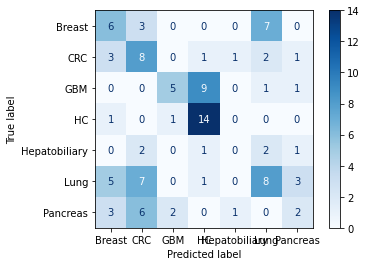

In [38]:
disp = ConfusionMatrixDisplay(cm, display_labels=y_pred_score.columns.values)
disp.plot(cmap="Blues")

## Good features >> fancy models

Picking a good model is important. However in the bioinformatics world, given the high variance driven by biological processes, machine learning usually means identifying the most generalizable features that represent the underlying biological mechanisms to build your models. Especially given the huge dimension of our feature space, the models tend to be easily overfit, hence finding the biological relevant features is usually the key to a generalizable model.

In the Best _et al._ paper, the authors selected [1,072 RNA transcripts](https://www.cell.com/cms/10.1016/j.ccell.2015.09.018/attachment/51eff62f-acac-4251-9a6e-e0a1b5061f93/mmc5) by building models and performing leave-one-out validation for each clss. Let's try using their gene list and see if it helps us building a good model. You can find the list of genes in the shared drive as well:

[pan_cancer_genes.txt](https://drive.google.com/file/d/1-1TCNFhEdXZWSaqytdWJkMp4htMywX5C/view?usp=sharing)

In [39]:
genes = np.loadtxt(DATA / "pan_cancer_genes.txt", delimiter="\n", dtype=str)

In [40]:
# Since we already convert the genes to gene symbol, we will miss some of the 
# ensg transcripts they use
common_genes = np.intersect1d(genes, x_train.columns.values)

In [41]:
train_data = x_train.loc[:, common_genes].copy()
train_data["cancer_type"] = y_train.values

predictor = TabularPredictor(label="cancer_type", path="good_quality_covid").fit( 
    train_data=train_data,
    presets="good_quality_faster_inference_only_refit",
    excluded_model_types=["CAT"] # exclude CatBoost model for it tends to run out of memory
)

INFO:autogluon.core.utils.decorators:Preset alias specified: 'good_quality_faster_inference_only_refit' maps to 'good_quality'.
INFO:autogluon.tabular.predictor.predictor:Presets specified: ['good_quality_faster_inference_only_refit']
INFO:autogluon.tabular.predictor.predictor:Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=5, num_bag_sets=1
INFO:autogluon.tabular.learner.default_learner:Beginning AutoGluon training ...
INFO:autogluon.tabular.learner.default_learner:AutoGluon will save models to "good_quality_covid/"
INFO:autogluon.tabular.learner.default_learner:AutoGluon Version:  0.5.2
INFO:autogluon.tabular.learner.default_learner:Python Version:     3.7.15
INFO:autogluon.tabular.learner.default_learner:Operating System:   Linux
INFO:autogluon.tabular.learner.default_learner:Train Data Rows:    177
INFO:autogluon.tabular.learner.default_learner:Train Data Columns: 977
INFO:autogluon.tabular.learner.default_learner:Label Column: cancer_type
INFO:autogluon.ta

In [42]:
# Backup the result
#!rsync -auzv good_quality_preselected_genes /content/drive/My\ Drive/ecbm_e4060_staging/

In [43]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                           model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0            WeightedEnsemble_L2   0.706215       3.219780   59.933645                0.000499           0.298055            2      False         11
1         NeuralNetFastAI_BAG_L1   0.700565       3.153610   33.696878                3.153610          33.696878            1      False          1
2          NeuralNetTorch_BAG_L1   0.661017       1.336861   17.990269                1.336861          17.990269            1      False          9
3              LightGBMXT_BAG_L1   0.627119       0.065671   25.938711                0.065671          25.938711            1      False          2
4                LightGBM_BAG_L1   0.576271       0.070547   37.841661                0.070547          37.841661            1      False          3
5           LightGBMLarge_BAG_L1   0.564972 

{'model_types': {'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1': 'StackerEnsembleModel_RF',
  'ExtraTreesGini_BAG_L1': 'StackerEnsembleModel_XT',
  'ExtraTreesEntr_BAG_L1': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'NeuralNetFastAI_BAG_L1_FULL': 'StackerEnsembleModel_NNFastAiTabular',
  'LightGBMXT_BAG_L1_FULL': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1_FULL': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1_FULL': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1_FULL': 'StackerEnsembleModel_RF',
  'ExtraTreesGini_BAG_L1_FULL': 'StackerEnsembleModel_XT',
  'E

In [44]:
test_data = x_test.loc[:, common_genes].copy()
y_pred_score = predictor.predict_proba(test_data)
y_pred = predictor.predict(test_data)

In [45]:
performance_scores(y_test, y_pred_score, y_pred)

{'accuracy': 0.5925925925925926,
 'balanced_accuracy': 0.5761054421768709,
 'auroc': 0.8805921878807369,
 'f1': 0.5771504566897521}

In [46]:
# make the target variable binary (tumor vs non-tumor)
y_test_bin = (y_test == "HC").astype(int)
y_pred_score_bin = y_pred_score["HC"]
y_pred_bin = (y_pred == "HC").astype(int)

In [47]:
performance_scores(y_test_bin, y_pred_score_bin, y_pred=y_pred_bin)

{'accuracy': 0.9166666666666666,
 'balanced_accuracy': 0.9510869565217391,
 'auroc': 0.9830163043478262,
 'f1': 0.9236701509872242}

You will find that the accuracy is also closer to what the paper reported (71% accuracy in Figure 2E).

In [48]:
cm = confusion_matrix(y_test, y_pred)

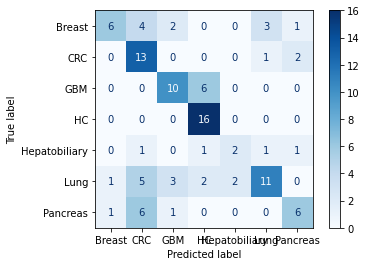

In [49]:
disp = ConfusionMatrixDisplay(cm, display_labels=y_pred_score.columns.values)
disp.plot(cmap="Blues")